In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as PSNR, structural_similarity as SSIM
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [2]:
HR_PATH = '/kaggle/input/d/oshanyalegama/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR'
LR_PATH = '/kaggle/input/d/oshanyalegama/div2k-dataset/DIV2K_train_LR_difficult/DIV2K_train_LR_difficult'

In [3]:
def load_images_lr(path):
    images = []
    img_files = sorted([img_file for img_file in os.listdir(path) if img_file.endswith('.png')])
    for img_file in img_files:
        img = keras.preprocessing.image.load_img(os.path.join(path, img_file), target_size=(128, 128))
        img = keras.preprocessing.image.img_to_array(img) / 255.0 
        images.append(img)
    return np.array(images)

In [4]:
def load_images_hr(path):
    images = []
    img_files = sorted([img_file for img_file in os.listdir(path) if img_file.endswith('.png')])
    for img_file in img_files:
        img = keras.preprocessing.image.load_img(os.path.join(path, img_file), target_size=(512, 512))
        img = keras.preprocessing.image.img_to_array(img) / 255.0 
        images.append(img)
    return np.array(images)

In [5]:
hr_images = load_images_hr(HR_PATH)
lr_images = load_images_lr(LR_PATH)

In [6]:
print(f'HR Images Shape: {hr_images.shape}')
print(f'LR Images Shape: {lr_images.shape}')

HR Images Shape: (800, 512, 512, 3)
LR Images Shape: (800, 128, 128, 3)


In [7]:
Valid_HR_PATH = '/kaggle/input/d/oshanyalegama/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR'
Valid_LR_PATH = '/kaggle/input/d/oshanyalegama/div2k-dataset/DIV2K_valid_LR_difficult/DIV2K_valid_LR_difficult'

In [8]:
Valid_hr_images = load_images_hr(Valid_HR_PATH)
Valid_lr_images = load_images_lr(Valid_LR_PATH)

In [9]:
print(f'HR Images Shape: {Valid_hr_images.shape}')
print(f'LR Images Shape: {Valid_lr_images.shape}')

HR Images Shape: (100, 512, 512, 3)
LR Images Shape: (100, 128, 128, 3)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(lr_images, hr_images, test_size=0.1, random_state=42)

In [11]:
X_test = Valid_lr_images
y_test = Valid_hr_images

In [12]:
print(f'HR Images Shape: {X_val.shape}')
print(f'LR Images Shape: {y_val.shape}')

HR Images Shape: (80, 128, 128, 3)
LR Images Shape: (80, 512, 512, 3)


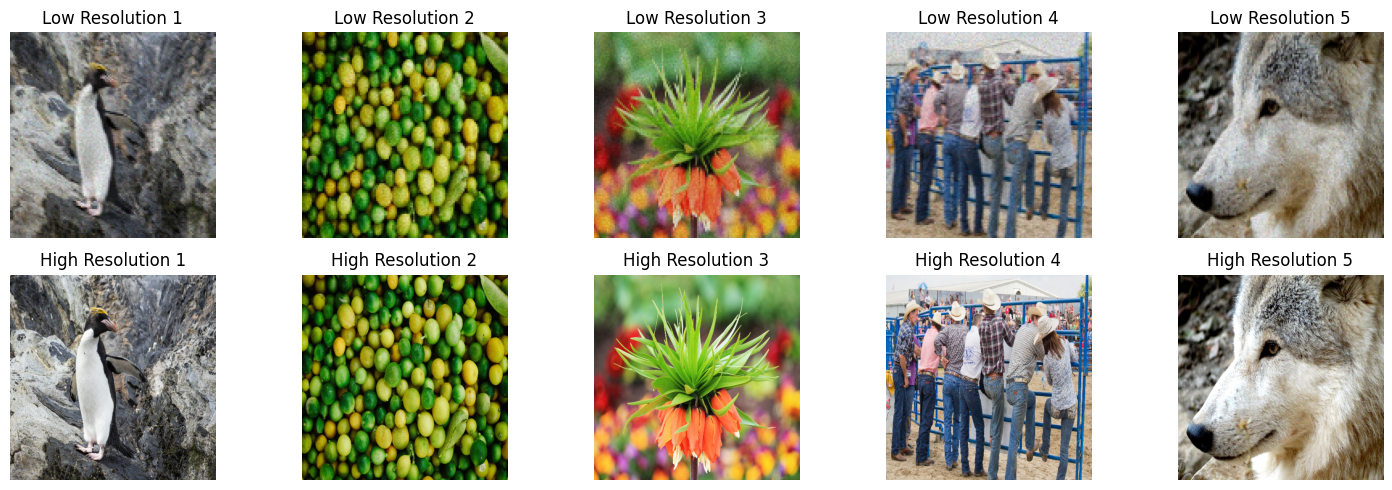

In [13]:
def display_initial_images(lr_images, hr_images, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(Valid_lr_images[i])
        plt.title(f'Low Resolution {i + 1}')
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(Valid_hr_images[i])
        plt.title(f'High Resolution {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_initial_images(X_train, y_train, num_images=5)

In [14]:
def create_edsr_model(scale_factor, num_blocks=16):
    inputs = layers.Input(shape=(128, 128, 3)) 

    x = layers.Conv2D(64, kernel_size=3, padding='same')(inputs)

    for _ in range(num_blocks):
        residual = x
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = layers.add([residual, x]) 

    x = layers.Conv2D(3, kernel_size=3, padding='same')(x)

    x = layers.Conv2D(64 * (scale_factor ** 2), kernel_size=3, padding='same')(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale_factor))(x)
    x = layers.Conv2D(3, kernel_size=3, padding='same')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [15]:
scale_factor = 4 
model = create_edsr_model(scale_factor=scale_factor)

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='mean_squared_error', 
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d[0][0],     │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ add[0][0],        │
│                     │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128,  │          0 │ add_1[0][0],      │
│                     │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_3[0][0]   

 Total params: 1,215,622 (4.64 MB)

 Trainable params: 1,215,622 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1727875695.603988     371 service.cc:145] XLA service 0x7e5404052ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727875695.604048     371 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727875709.783919     371 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 336ms/step - accuracy: 0.3367 - loss: 0.2042 - val_accuracy: 0.3441 - val_loss: 0.0302
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.3834 - loss: 0.0284 - val_accuracy: 0.5292 - val_loss: 0.0241
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.5482 - loss: 0.0228 - val_accuracy: 0.7128 - val_loss: 0.0193
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.6590 - loss: 0.0197 - val_accuracy: 0.7122 - val_loss: 0.0183
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.6697 - loss: 0.0181 - val_accuracy: 0.7312 - val_loss: 0.0182
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.6925 - loss: 0.0174 - val_accuracy: 0.7642 - val_loss: 0.0170
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.7336 - loss: 0.0167 - val_accuracy: 0.7720 - val_loss: 0.0168
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.7496 - loss: 0.0162 - val_accuracy: 0.778

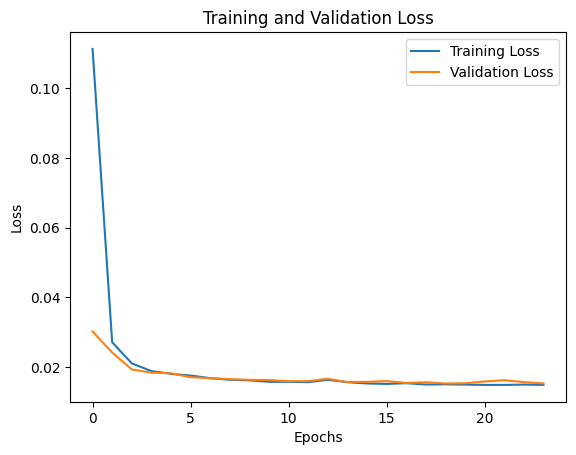

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

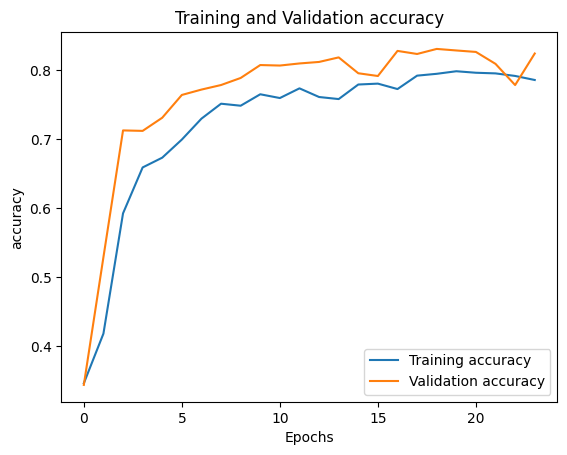

In [35]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [20]:
y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 723ms/step


In [28]:
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
psnr = PSNR(y_test, y_pred, data_range=y_pred.max() - y_pred.min())
data_range = 1.0 if y_pred.max() <= 1.0 else 255.0  
ssim = SSIM(y_test, y_pred, multichannel=True, win_size=win_size, data_range=data_range)

In [29]:
print(f'Mean Squared Error: {mse:.4f}')
print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr:.4f} dB')
print(f'Structural Similarity Index (SSIM): {ssim:.4f}')

Mean Squared Error: 0.0157
Peak Signal-to-Noise Ratio (PSNR): 21.4426 dB
Structural Similarity Index (SSIM): 0.9994
